# Spatial Correlations of bacterial suspensions

Here we use spatial correlaitons (orientation, velocity and pixel intensity) to identify the transition from disordered phase to ordered phase. 

We also compare the concentration dependence of correlation length with that of GNF scaling exponent $\alpha$.

## 1. Packages and presets

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd
import time

In [2]:
# figure initializing presets
presets = {}
presets['1-column-2-panel'] = (1.25, 1.57, 157)
presets['1-column-1-panel'] = (1.25, 3.2, 157)
h, w, dpi = presets['1-column-2-panel']

In [3]:
# matplotlib configs

# FONT
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.usetex'] = True 

# FIGURE
matplotlib.rcParams['figure.figsize'] = w, h
matplotlib.rcParams['figure.dpi'] = dpi

# AXES
matplotlib.rcParams['axes.labelpad'] = 1.0
matplotlib.rcParams['axes.labelsize'] = 'small'
matplotlib.rcParams['axes.linewidth'] = 0.5

# TICKS
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.major.size'] = 2.5
matplotlib.rcParams['xtick.minor.size'] = 1.6

matplotlib.rcParams['ytick.labelsize'] = 'small'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.major.size'] = 2.5
matplotlib.rcParams['ytick.minor.size'] = 1.6

# LEGEND
matplotlib.rcParams['legend.labelspacing'] = 0.2
matplotlib.rcParams['legend.handlelength'] = 1
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.handletextpad'] = 0.2
matplotlib.rcParams['legend.columnspacing'] = 0.5
matplotlib.rcParams['legend.frameon'] = False

## 2. intensity, orientation and velocity spatial correlation

### 2.1 Helper functions

- Exponential function: for fitting the spatial correlations 
- corr_length: extract correlation length
- xy_to_r: spatial correlation data was originally recorded in (x, y, CA, CV). This function converts the x, y to r by 
$$ r = \sqrt{x^2+y^2} $$

    **Note:** (x, y) in the data starts from the first nonzero distance (step, step), where as the correlation value (CA, CV) starts from distance (0, 0). Here, we manually adjust the (x, y) by 
$$ x, y = x-step, y-step $$
    to get meaningful spatial correlation data.

- average_data: take the average of all data in given directory

<font color='red'><b> Comment to myself: </b></font> in the future, I will change the distance representation in the corr code. Also, the code now has too many for loops which surely harm the performance. I will try to vectorize it.

In [4]:
def exp(x, a):
    return np.exp(-a*x)

**Fit data with exponential**

The correlation functions are all identified as exponential decay. In order to determine the length scale of the correlation function, I need to fit the functions with exponential $$y = be^{-ax}$$

In [5]:
def corr_length(data, fitting_range=None):
    """
    Args:
    data -- dataframe with columns (R, C), where R has pixel as unit
    fitting_range -- (optional) can be None, int or list of two int
    
    Returns:
    cl -- correlation length of given data (pixel)
    """
    if fitting_range == None:
        pass
    elif isinstance(fitting_range, int):
        data = data.loc[data['R'] < fitting_range]
    elif isinstance(fitting_range, list) and len(fitting_range) == 2:
        data = data.loc[(data['R'] < fitting_range[1])&(data['R'] >= fitting_range[0])]
    else:
        raise ValueError('fitting_range should be None, int or list of 2 int')
        
    fit = curve_fit(exp, data['R'], data['C'], p0=[0.01])
    cl = 1 / fit[0][0]
    return cl, fit

In [6]:
def xy_to_r(corr_xy):
    """
    Note, this version of function converts the xy data where x, y start from (step, step) instead of (0, 0).
    When the corr functions are changed, this function should not be used anymore. 
    Check carefully before using.
    
    Args:
    corr_xy -- DataFrame of (X, Y, ...)
    
    Returns:
    corr_r -- DataFrame (R, ...)
    """
    step_x = corr_xy.X.iloc[0]
    step_y = corr_xy.Y.iloc[0]
    corr_r = corr_xy.assign(R = ((corr_xy.X-step_x)**2 + (corr_xy.Y-step_y)**2)**0.5)    
    return corr_r

In [7]:
corr_xy = pd.read_csv(r'E:\Github\Python\Correlation\test_images\CAV\cav_result\900-901.csv')
corr_r = xy_to_r(corr_xy)
corr_r.head()

,X,Y,CA,CV,R
0,25.0,25.0,1.000000,1.000000,0.0
1,50.0,25.0,0.912503,0.947867,25.0
2,75.0,25.0,0.792586,0.855965,50.0
3,100.0,25.0,0.685544,0.754280,75.0
4,125.0,25.0,0.583561,0.646617,100.0


In [17]:
def average_data(directory, columns=['CA', 'CV']):
    """
    Take the average of all data in given directory
    
    Args:
    directory -- folder which contains *.csv data, with columns
    columns -- (optional) list of column labels of columns to be averaged
    
    Returns:
    averaged -- DataFrame with averaged data
    """
    k = 0
    
    l = corrLib.readdata(directory)
    for num, i in l.iterrows():
        data = pd.read_csv(i.Dir)
        # check if given label exists in data
        for label in columns:
            if label not in data:
                raise IndexError('Column \'{0}\' does not exist in given data'.format(label))
        if k == 0:
            temp = data[columns]
        else:
            temp += data[columns]
        k += 1                   
       
    # finally, append all other columns (in data but not columns) to averaged
    other_cols = []
    for label in data.columns:
        if label not in columns:
            other_cols.append(label) 
    
    averaged = pd.concat([temp / k, data[other_cols]], axis=1)       
    
    return averaged 

In [9]:
# test
d = r'E:\Github\Python\Correlation\test_images\CAV\cav_result'
tic = time.monotonic()
averaged = average_data(d, columns=['CA', 'CV'])
toc = time.monotonic()
print('time needed for 2 files: {:.3} ms'.format((toc-tic)*1000))
print(averaged.head())

time needed for 2 files: 47.0 ms
         CA        CV      X     Y
0  1.000000  1.000000   25.0  25.0
1  0.914361  0.948507   50.0  25.0
2  0.795402  0.857086   75.0  25.0
3  0.687169  0.756254  100.0  25.0
4  0.585534  0.650149  125.0  25.0


## 2.2 Concentration correlation

#### 2.2.1 Plot concentration correlation functions

Since the plot functions for concentration, orientation and velocity are very similar, I integrate them into one function ```plot_correlation(data, mpp, lb)```, where data should have (R, C, conc). 

In [126]:
def plot_correlation(data, plot_cols=['R', 'C'], xlim=None, mpp=0.33, lb=3, plot_raw=False):
    """
    Plot correlation data. Here we plot the exponential function fitting instead of raw data so that the curve look better.
    
    Args:
    data -- DataFrame (R, C, conc)
    plot_cols -- specify columns to plot. The first column should be distance and the second is correlation
    xlim -- trim the xdata, only use those in the range of xlim
    mpp -- microns per pixel 
    lb -- bacteria size in um
    
    Returns:
    ax -- the axis of plot, one can use this handle to add labels, title and other stuff   
    """
    
    # Initialization
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    cl_data = {'conc': [], 'cl': []}
    symbol_list = ['o', '^', 'x', 's', '+']
    data = data.sort_values(by=[plot_cols[0], 'conc'])
    
    # process data, apply xlim
    if xlim == None:
        pass
    elif isinstance(xlim, int):
        data = data.loc[data[plot_cols[0]] < xlim]
    elif isinstance(xlim, list) and len(xlim) == 2:
        data = data.loc[(data[plot_cols[0]] < xlim[1])&(data[plot_cols[0]] >= xlim[0])]
    else:
        raise ValueError('xlim must be None, int or list of 2 ints')
    
    for num, nt in enumerate(data.conc.drop_duplicates()):
        subdata = data.loc[data.conc==nt]
        x = subdata[plot_cols[0]]
        y = subdata[plot_cols[1]]
        p, po = curve_fit(exp, x, y, p0=[0.01])
        xfit = np.linspace(0, x.max(), num=50)
        yfit = exp(xfit, *p)
        if plot_raw:
            ax.plot(x*mpp/lb, y, color=wowcolor(num), lw=1, ls='--')
        ax.plot(xfit*mpp/lb, yfit, mec=wowcolor(num), label=str(nt), ls='',
                marker=symbol_list[num], mfc=(0,0,0,0), markersize=4, markeredgewidth=0.5)
        cl_data['conc'].append(int(nt))
        cl_data['cl'].append(1/p[0])
    
    ax.legend()     
    return ax, pd.DataFrame(cl_data).sort_values(by='conc')

Text(0, 0.5, '$C_{n}$')

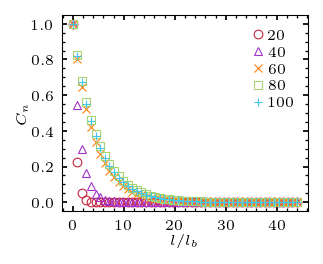

In [102]:
# test 
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
ax, cl_data = plot_correlation(data, xlim=400)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{n}$')

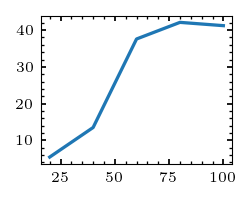

In [75]:
plt.plot(cl_data['conc'], cl_data['cl'])

#### 2.2.2 Extract correlation lengths

Text(0.5, 0, '$n$ [n$_0$]')

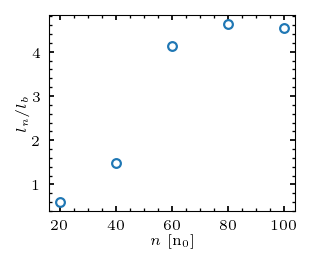

In [33]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33
lb = 3

cl_data = {'conc': [], 'cl': []}
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl, fit = corr_length(subdata, fitting_range=None)
    cl_data['conc'].append(nt)
    cl_data['cl'].append(cl)
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

c = np.array(cl_data['conc'])
l = np.array(cl_data['cl']) * mpp / lb
ax.plot(c, l, mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.set_ylabel('$l_n/l_b$')
ax.set_xlabel('$n$ [n$_0$]')  

## 2.3 Orientation and velocity correlations

#### 2.3.1 Plot orientation and velocity correlations

**Construct all-in-one data:**
    
Before calling a function which plots the data, we first reorganize the data in a DataFrame with (R, CA, CV, conc) by using

- average_data(directory)
- xy_to_r(corr_xy)
- assign conc column

In [53]:
# First average data over time for each sample
folder = r'E:\moreData\02042020\cav_imseq'
l = next(os.walk(folder))[1]
for s in l:
    d = os.path.join(folder, s)
    avg = average_data(d, columns=['CA', 'CV'])
    avg.to_csv(os.path.join(folder, s+'.csv'), index=False)

In [54]:
# convert from xy to r and save in corresponding folder
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\xy'
l = corrLib.readdata(folder)
for num, i in l.iterrows():
    conc = i.Name.split('-')[0]
    dest_folder = folder.replace('xy', conc)
    data_xy = pd.read_csv(i.Dir)
    data_r = xy_to_r(data_xy)
    data_r.to_csv(os.path.join(dest_folder, i.Name+'.csv'), index=False)

In [57]:
# average over concentration and combine into one file corrAV.csv
sfL = ['20', '40', '60', '80', '100']
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
for num, s in enumerate(sfL):
    d = os.path.join(folder, s)
    avg = average_data(d, columns=['CA', 'CV']).assign(conc=s)
    if num == 0:
        data = avg
    else:
        data = data.append(avg)
data.to_csv(os.path.join(folder, 'corrAV.csv'), index=False)

<font color='green'><b>Here, corrAV.csv is the all-in-one orientation and velocity correlation data, with columns (R, CA, CV)</b></font>

In [56]:
data

,CA,CV,X,Y,R,conc
0,1.000000,1.000000,25.0,25.0,0.000000,20
1,0.658120,0.742498,50.0,25.0,25.000000,20
2,0.439618,0.505862,75.0,25.0,50.000000,20
3,0.315523,0.360884,100.0,25.0,75.000000,20
4,0.225330,0.256673,125.0,25.0,100.000000,20
...,...,...,...,...,...,...
6395,0.249035,0.000056,NaN,NaN,2793.295545,100
6396,0.123486,0.000050,NaN,NaN,2793.295545,100
6397,-0.095569,0.000006,NaN,NaN,2810.805045,100
6398,-0.123317,0.000009,NaN,NaN,2810.805045,100


**<font color='red'>Plot data using plot_concentration()</font>**
    
<font color='red'>This block has data inconsistencies which require further invesigation. Do not use the plots here, down to the ISSUE cell.

Text(0, 0.5, '$C_{A}$')

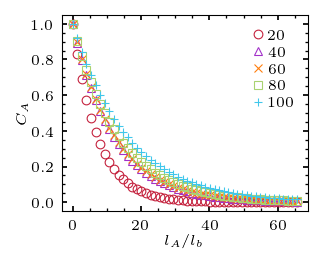

In [132]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\corrAV.csv').drop(columns=['X', 'Y']).dropna()
ax, cl_data = plot_correlation(data, xlim=600, plot_cols=['R', 'CV'])
ax.set_xlabel('$l_A/l_b$')
ax.set_ylabel('$C_{A}$')

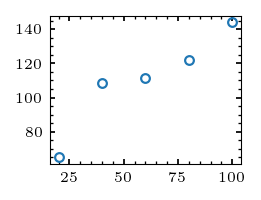

In [133]:
plt.plot(cl_data['conc'], cl_data['cl'], mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)

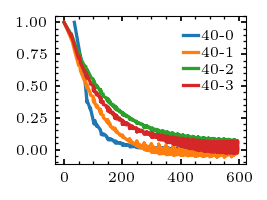

In [98]:
# look at 40 n0 four runs see if there is an outlier
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\40'
l = corrLib.readdata(folder)
for num, i in l.iterrows():
    data = pd.read_csv(i.Dir).sort_values(by='R')
    data = data.loc[data.R < 600]
    plt.plot(data.R, data.CV, label=i.Name)    
plt.legend()

<font color='red'><b> ISSUE: </b> this seemingly okay exponential decay shows completely different correlation length trend than we I saw before. Instead of showing a sudden increase after 40 n$_0$, and plateaus at high concentration end, it shows a gradual increase through out the whole concentration range. This change in observation comes from averaging more data with same concentration but from different batch of experiments together. I have also plotted above how different these data are where as they are supposed to be the same. I won't show this to Xiang on Wed, July 29th, but will surely keep looking into it. At the moment, I plot spatial correlations using the old data: spatialCorrA.csv, spatialCorrA.csv and  spatialCorr_crop.csv.</font> 

**Plot orientation correlation**

Text(0, 0.5, '$C_{A}$')

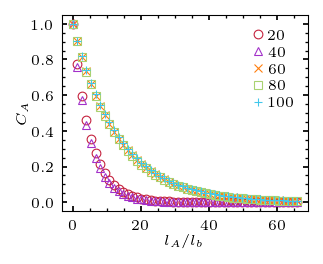

In [176]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrA.csv')
data.R = data.R - data.R.min()
ax, cl_data = plot_correlation(data, xlim=600, plot_cols=['R', 'C'])
ax.set_xlabel('$l_A/l_b$')
ax.set_ylabel('$C_{A}$')

Text(0, 0.5, '$l_A/l_b$')

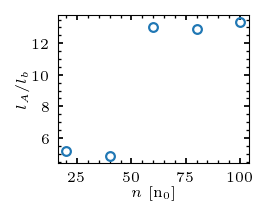

In [177]:
# this cell uses cl_data variable which comes from the cell above, run the above cell before this one, otherwise error will occur
# or you may be plotting cl_data from other data
plt.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_A/l_b$')

**Plot velocity correlation**

Text(0, 0.5, '$C_{v}$')

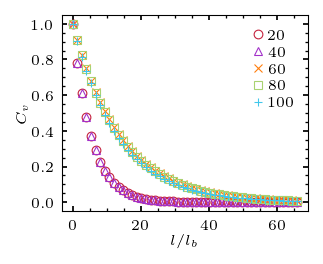

In [174]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrV.csv')
data.R = data.R - data.R.min()
ax, cl_data = plot_correlation(data, xlim=600, plot_cols=['R', 'C'])
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{v}$')

Text(0, 0.5, '$l_A/l_b$')

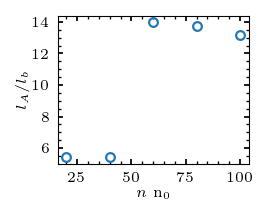

In [175]:
# this cell uses cl_data variable which comes from the cell above, run the above cell before this one, otherwise error will occur
# or you may be plotting cl_data from other data
plt.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
plt.xlabel('$n$ n$_0$')
plt.ylabel('$l_A/l_b$')

### 2.4 Plot all correlation lengths in the same axis

Text(0, 0.5, '$C_v$')

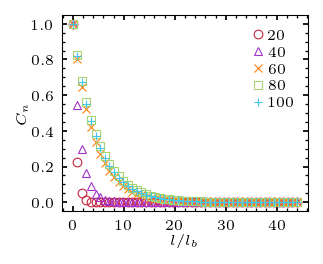

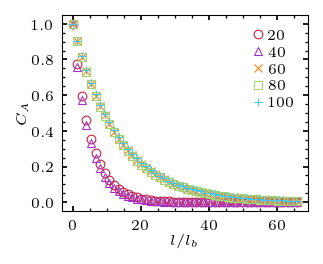

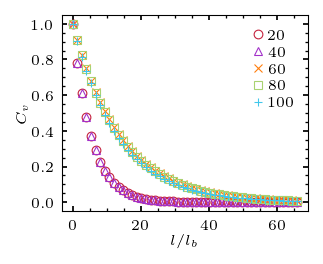

In [178]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
data.R = data.R - data.R.min()
ax, cl_data = plot_correlation(data, xlim=400)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_n$')
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrA.csv')
data.R = data.R - data.R.min()
ax, cla_data = plot_correlation(data, xlim=600)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_A$')
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrV.csv')
data.R = data.R - data.R.min()
ax, clv_data = plot_correlation(data, xlim=600)
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_v$')

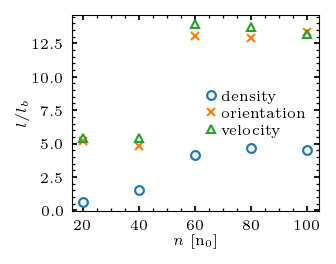

In [179]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='', label='density',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.plot(cla_data['conc'], cla_data['cl']*0.33/3, mec=bestcolor(1), ls='', label='orientation',
                marker='x', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.plot(clv_data['conc'], clv_data['cl']*0.33/3, mec=bestcolor(2), ls='', label='velocity',
                marker='^', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$l/l_b$')
ax.legend()

**Plot concentration correlation length on a different scale**

Since concentration correlation length is much smaller than other two, I'd like to plot it on a different scale to highlight the similarity between the three quantities -- sudden increase at the onset of collective motion.

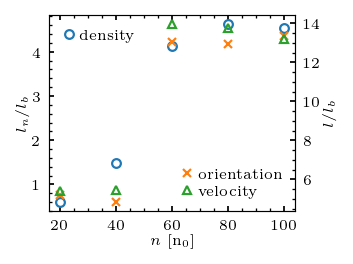

In [180]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(cl_data['conc'], cl_data['cl']*0.33/3, mec=bestcolor(0), ls='', label='density',
                marker='o', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax1 = ax.twinx()
ax1.plot(cla_data['conc'], cla_data['cl']*0.33/3, mec=bestcolor(1), ls='', label='orientation',
                marker='x', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax1.plot(clv_data['conc'], clv_data['cl']*0.33/3, mec=bestcolor(2), ls='', label='velocity',
                marker='^', mfc=(0,0,0,0), markersize=4, markeredgewidth=1)
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$l_n/l_b$')
ax1.set_ylabel('$l/l_b$')
ax.legend()
ax1.legend()

### <font color='gray'>2.5 Does smoothing in PIV change velocity correlation length?</font>
    
Since this section is purely out of curiosity and will not be in the main paper, I color the title ``gray`` so that it looks unimportant. Actually, this is still essential to our work since it can potentially change my analysis. This is technical. 

In [160]:
# collect and process data
folder = {}
avg = {}
avg_r = {}
folder['n'] = r'E:\moreData\02042020\cav_imseq_nosmooth\20-1' # no smoothing
folder['s'] = r'E:\moreData\02042020\cav_imseq\20-1' # smoothing
for kw in folder:    
    avg[kw] = average_data(folder[kw], columns=['CA', 'CV'])
    avg_r[kw] = xy_to_r(avg[kw])

Text(0, 0.5, '$C_V$')

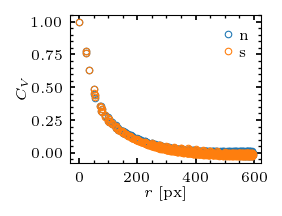

In [161]:
# plot data
count = 0
for kw in avg_r:
    avg_r[kw] = avg_r[kw].sort_values(by=['R'])
    avg_r[kw] = avg_r[kw].loc[avg_r[kw]['R']<600]
    plt.plot(avg_r[kw]['R'], avg_r[kw]['CV'], label=kw, ls='', marker='o', mec=bestcolor(count), mfc=(0,0,0,0),
            mew=0.5, markersize=3)
    count += 1
plt.legend()
plt.xlabel('$r$ [px]')
plt.ylabel('$C_V$')

## 3. Compare spatial correlations and GNF

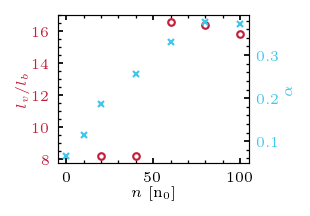

In [172]:
mpp = 0.33
lb = 3 # um
cs = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig2-GNF\conc-slope.csv')
n = [20, 40, 60, 80, 100]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = wowcolor(0)
ax1.plot(clv_data['conc'], clv_data['cl']*mpp/lb, ls='', marker='o', mec=color, mfc=(0,0,0,0),
        markersize=3, mew=1)
ax1.set_xlabel('$n$ [n$_0$]')
ax1.set_ylabel('$l_v/l_b$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = wowcolor(4)
ax2.plot(cs.conc, cs.slope, ls='', marker='x', mec=color, mfc=(0,0,0,0),
        markersize=3, mew=1)
ax2.set_ylabel('$\\alpha$', color=color)
ax2.tick_params(axis='y', labelcolor=color)

## 4. Density correlation function in Fourier space

Quite a few theory papers like to investigate density correlation and fluctuation in Fourier space. I don't get it yet how it works. I will try to figure it out if I have time. 

In [28]:
I = np.random.randn(100, 100)
I[I < 0.9] = 0